In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported")

Libraries imported


In [2]:
model_name = 'bert-base-uncased'
num_labels = 3
max_length = 128
batch_size = 16
num_epochs = 3
learning_rate = 2e-5
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
texts = [
    "Company reports record quarterly profits exceeding expectations",
    "Stock market reaches all-time high with strong gains",
    "Federal Reserve announces stimulus boosting investor confidence",
    "Tech company shares surge 8% after innovation announcement",
    "Strong job growth indicates economic recovery",
    "Merger announcement sends stocks soaring",
    "Bank adoption of cryptocurrency signals mainstream acceptance",
    "GDP growth exceeds forecasts showing economic expansion",
    "Company files for bankruptcy amid mounting debts",
    "Market crashes as recession fears grip investors",
    "Unemployment rate rises sharply concerning economists",
    "Major bank reports significant losses from bad loans",
    "Trade war escalates causing market volatility",
    "Company shares plummet 20% after product recall",
    "Economic indicators point to potential recession",
    "Corporate earnings disappoint leading to selloff",
    "Federal Reserve maintains interest rates unchanged",
    "Company releases earnings in line with expectations",
    "Trading volume remains steady as investors wait",
    "Board announces regular quarterly dividend",
    "Market closes mixed with minor changes",
    "Company announces CEO transition",
    "Annual shareholder meeting scheduled",
    "Regulatory filing submitted for compliance",
]

labels = [
    0, 0, 0, 0, 0, 0, 0, 0,
    1, 1, 1, 1, 1, 1, 1, 1,
    2, 2, 2, 2, 2, 2, 2, 2
]

texts = texts * 20
labels = labels * 20

df = pd.DataFrame({'text': texts, 'label': labels})
print(f"Dataset size: {len(df)}")

# %%
label_counts = df['label'].value_counts().sort_index()
print("Label distribution:")
print(f"Positive (0): {label_counts[0]}")
print(f"Negative (1): {label_counts[1]}")
print(f"Neutral (2): {label_counts[2]}")

# %%
X_train, X_val, y_train, y_val = train_test_split(
    df['text'].values,
    df['label'].values,
    test_size=0.2,
    random_state=seed,
    stratify=df['label'].values
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

# %%
tokenizer = BertTokenizer.from_pretrained(model_name)
print(f"Tokenizer loaded")
print(f"Vocabulary size: {tokenizer.vocab_size}")


Dataset size: 480
Label distribution:
Positive (0): 160
Negative (1): 160
Neutral (2): 160
Training samples: 384
Validation samples: 96


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizer loaded
Vocabulary size: 30522


In [4]:
class FinancialDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("Dataset class defined")

Dataset class defined


In [5]:
train_dataset = FinancialDataset(X_train, y_train, tokenizer, max_length)
val_dataset = FinancialDataset(X_val, y_val, tokenizer, max_length)

print(f"Train dataset created: {len(train_dataset)} samples")
print(f"Validation dataset created: {len(val_dataset)} samples")

# %%
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

print("BERT model loaded")
print(f"Model type: {model_name}")
print(f"Number of labels: {num_labels}")

# %%
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2,
    seed=seed,
    report_to="none"
)

print("Training arguments set")

# %%
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

print("Trainer created")

# %%
print("Starting training...")
print("-" * 50)

train_result = trainer.train()

print("Training completed!")

# %%
train_loss = train_result.metrics['train_loss']
print(f"Final training loss: {train_loss:.4f}")

# %%
print("Evaluating on validation set...")

eval_results = trainer.evaluate()

print("Evaluation results:")
print(f"Validation loss: {eval_results['eval_loss']:.4f}")

# %%
print("Getting predictions...")

predictions = trainer.predict(val_dataset)

predicted_probs = predictions.predictions
predicted_classes = np.argmax(predicted_probs, axis=1)
true_labels = predictions.label_ids

print(f"Predictions shape: {predicted_classes.shape}")
print(f"True labels shape: {true_labels.shape}")

# %%
correct_predictions = 0
total_predictions = len(predicted_classes)

for i in range(len(predicted_classes)):
    if predicted_classes[i] == true_labels[i]:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"Validation Accuracy: {accuracy:.4f}")

# %%
confusion_matrix_values = np.zeros((3, 3), dtype=int)

for i in range(len(true_labels)):
    true_label = true_labels[i]
    predicted_label = predicted_classes[i]
    confusion_matrix_values[true_label][predicted_label] += 1

print("Confusion Matrix:")
print(confusion_matrix_values)

Train dataset created: 384 samples
Validation dataset created: 96 samples


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded
Model type: bert-base-uncased
Number of labels: 3
Training arguments set
Trainer created
Starting training...
--------------------------------------------------


Epoch,Training Loss,Validation Loss
1,1.110000,1.069240
2,1.023500,0.944021
3,0.807300,0.670338


Training completed!
Final training loss: 0.9990
Evaluating on validation set...


Evaluation results:
Validation loss: 0.6703
Getting predictions...
Predictions shape: (96,)
True labels shape: (96,)
Validation Accuracy: 1.0000
Confusion Matrix:
[[32  0  0]
 [ 0 32  0]
 [ 0  0 32]]


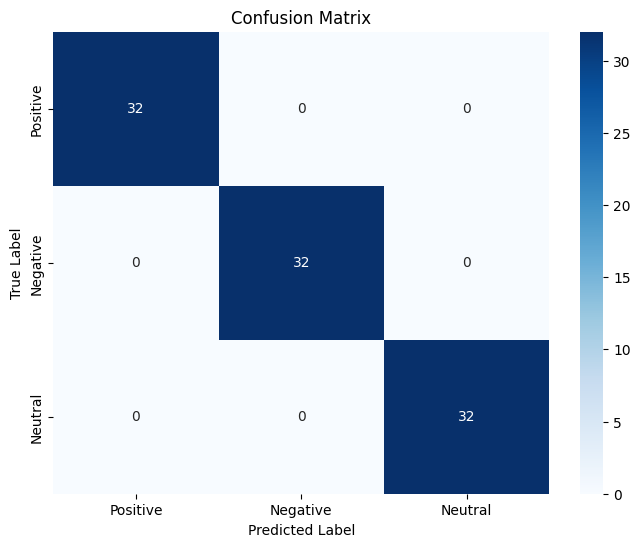


Per-class metrics:
--------------------------------------------------

Positive:
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

Negative:
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

Neutral:
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000


In [6]:
label_names = ['Positive', 'Negative', 'Neutral']

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_values, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# %%
print("\nPer-class metrics:")
print("-" * 50)

for class_idx in range(3):
    tp = confusion_matrix_values[class_idx][class_idx]

    fp = 0
    for i in range(3):
        if i != class_idx:
            fp += confusion_matrix_values[i][class_idx]

    fn = 0
    for j in range(3):
        if j != class_idx:
            fn += confusion_matrix_values[class_idx][j]

    if (tp + fp) > 0:
        precision = tp / (tp + fp)
    else:
        precision = 0

    if (tp + fn) > 0:
        recall = tp / (tp + fn)
    else:
        recall = 0

    if (precision + recall) > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0

    print(f"\n{label_names[class_idx]}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")



Testing on new examples:
--------------------------------------------------

Text: Tech company announces breakthrough, stock jumps 12%
Predicted class: Positive
Confidence: 0.4615
All probabilities:
  Positive: 0.4615
  Negative: 0.2950
  Neutral: 0.2435

Text: Global recession fears cause market crash
Predicted class: Negative
Confidence: 0.4387
All probabilities:
  Positive: 0.3809
  Negative: 0.4387
  Neutral: 0.1803

Text: Company maintains steady growth as expected
Predicted class: Positive
Confidence: 0.4441
All probabilities:
  Positive: 0.4441
  Negative: 0.2379
  Neutral: 0.3179


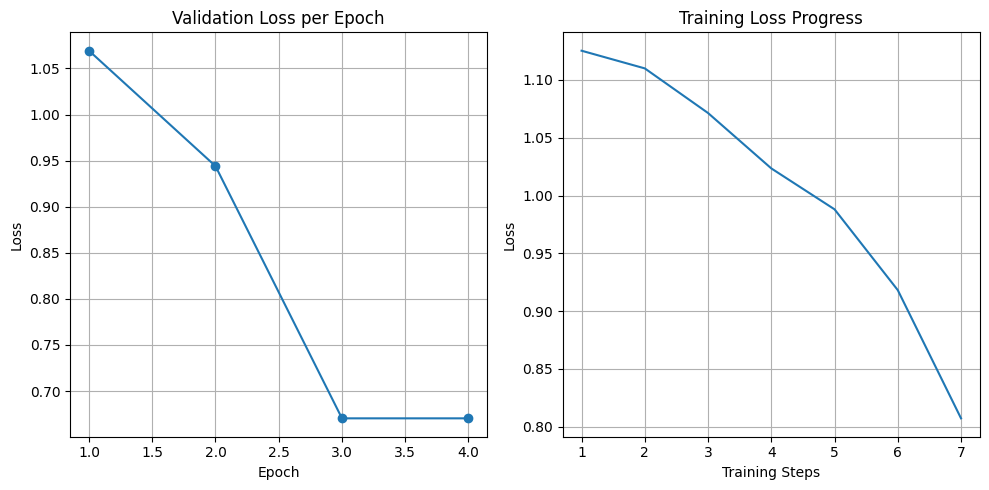

Model saved to: ./financial_bert_model
Model loaded successfully

Test with loaded model:
Text: Stock market shows positive momentum
Prediction: Positive

TRAINING SUMMARY
Model: bert-base-uncased
Training samples: 384
Validation samples: 96
Number of epochs: 3
Batch size: 16
Final validation accuracy: 100.00%
Final training loss: 0.9990
Final validation loss: 0.6703
Notebook completed successfully!


In [7]:
test_sentences = [
    "Tech company announces breakthrough, stock jumps 12%",
    "Global recession fears cause market crash",
    "Company maintains steady growth as expected"
]

print("\nTesting on new examples:")
print("-" * 50)

for sentence in test_sentences:
    inputs = tokenizer(
        sentence,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        probs = torch.softmax(logits, dim=-1)

        predicted_class = torch.argmax(probs, dim=-1).item()
        confidence = torch.max(probs).item()

    print(f"\nText: {sentence}")
    print(f"Predicted class: {label_names[predicted_class]}")
    print(f"Confidence: {confidence:.4f}")

    print("All probabilities:")
    print(f"  Positive: {probs[0][0].item():.4f}")
    print(f"  Negative: {probs[0][1].item():.4f}")
    print(f"  Neutral: {probs[0][2].item():.4f}")

# %%
training_loss_history = []
validation_loss_history = []

for log in trainer.state.log_history:
    if 'loss' in log:
        training_loss_history.append(log['loss'])
    if 'eval_loss' in log:
        validation_loss_history.append(log['eval_loss'])

if len(validation_loss_history) > 0:
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    epochs = range(1, len(validation_loss_history) + 1)
    plt.plot(epochs, validation_loss_history, 'o-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss per Epoch')
    plt.grid(True)

    if len(training_loss_history) > 0:
        plt.subplot(1, 2, 2)
        steps = range(1, len(training_loss_history) + 1)
        plt.plot(steps, training_loss_history, label='Training Loss')
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.title('Training Loss Progress')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# %%
model_save_path = './financial_bert_model'

trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to: {model_save_path}")

# %%
from transformers import BertForSequenceClassification, BertTokenizer

loaded_model = BertForSequenceClassification.from_pretrained(model_save_path)
loaded_tokenizer = BertTokenizer.from_pretrained(model_save_path)

loaded_model = loaded_model.to(device)
loaded_model.eval()

print("Model loaded successfully")

test_text = "Stock market shows positive momentum"

test_inputs = loaded_tokenizer(
    test_text,
    return_tensors='pt',
    padding=True,
    truncation=True,
    max_length=max_length
)

test_inputs = {k: v.to(device) for k, v in test_inputs.items()}

with torch.no_grad():
    test_outputs = loaded_model(**test_inputs)
    test_logits = test_outputs.logits
    test_probs = torch.softmax(test_logits, dim=-1)
    test_prediction = torch.argmax(test_probs, dim=-1).item()

print(f"\nTest with loaded model:")
print(f"Text: {test_text}")
print(f"Prediction: {label_names[test_prediction]}")

# %%
print("\n" + "=" * 50)
print("TRAINING SUMMARY")
print("=" * 50)
print(f"Model: {model_name}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Final validation accuracy: {accuracy:.2%}")
print(f"Final training loss: {train_loss:.4f}")
print(f"Final validation loss: {eval_results['eval_loss']:.4f}")
print("=" * 50)

# %%
print("Notebook completed successfully!")